# Data Exploration for Green Roof Diagnostics

The purpose of this notebook is to find the "linear reservoir coefficients", essentially a "water balance" approach to looking at the data.  We want to understand which independent variables strongly affect the dependent variable of absorption.  Absorption being the green roof holds holds onto water, even for 1 increment.  

Independent Variables in data set suspected to significantly affect absorption:
- AMC (antecedent moisture condition)
- Thickness of soil
- Thickness of retention layer
- Type of drainage layer
- Slope
- Intensity of rainfall

Independent Variables NOT in data set suspected to significantly affect absorption:
- Capillarity of soil (currently all the same)
- Capillarity of retention layer (currently all the same)
- Capillary differential between soil and retention layer (currently all the same)
- Permeability of soil (currently all the same)
- Transmissivity of drainage layer (we have a few different types)

Independent Variables in data set suspected NOT to significantly affect absorption:
- Plant coverage or health (suspected to strongly affect evapotranspiration, but not absorption)
- Surface roughness (same in all cases, suspected only to impact sheet flow, of which we have little)
- Surface slope (same as overall slope)

What we need to confirm:
Is the first group correct? I.e. does each variable significantly affect absorption?
What is the weight of each variable in the first group?  

## Data Engineering

The test, labhifreq and profiles tables will be joined. Then, in order to eliminate rows where the data logger was on but not collecting relevant data, the rows where the id_test value is null will be dropped. Secondly, tests 13, 15, 21, 22, 109, 170, and 217 will be dropped as there were errors in these tests. Finally, all rows with mins_total from 1-4 will be dropped. The reason for removing these rows is that the data may be incorrect in this range, as the instruments may be callibrating:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math
import seaborn as sns 
# import labhifreq
path_labhifreq = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-2-19-19/labhifreq.csv'
labhifreq = pd.read_csv(path_labhifreq)
# drop rows where id_test is null
labhifreq = labhifreq[~labhifreq['id_test'].isnull()]
# drop columns shared with test.csv
labhifreq = labhifreq.drop(['timestamp_created', 'id_storm', 'notes', 'bad_data', 'panel_temp_c', 
                            'rain_temp_c'], 1)
# reset index of labhifreq to id_test for join
labhifreq = labhifreq.reindex()
# remove bad tests
labhifreq = labhifreq[labhifreq.id_test != 13]
labhifreq = labhifreq[labhifreq.id_test != 15]
labhifreq = labhifreq[labhifreq.id_test != 21]
labhifreq = labhifreq[labhifreq.id_test != 22]
labhifreq = labhifreq[labhifreq.id_test != 109]
labhifreq = labhifreq[labhifreq.id_test != 170]
labhifreq = labhifreq[labhifreq.id_test != 217]
# import test table
path_tests = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-2-19-19/tests.csv'
tests = pd.read_csv(path_tests)
# join test and labhifreq tables
df = tests[['id_test', 'id_cassette', 'runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 
            'slope_pct']].merge(labhifreq, on='id_test')
# import cassettes
path_cassettes = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-2-19-19/cassettes.csv'
cassettes = pd.read_csv(path_cassettes)
# drop all except connectors 
cassettes = cassettes[['id_cassette', 'id_profile']]
# join cassette and df tables
df = df.merge(cassettes, on='id_cassette')
# import platforms
path_profiles = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-2-19-19/profiles.csv'
profiles = pd.read_csv(path_profiles)
# drop redundant columns
profiles = profiles[['id_profile', 'media_thickness_in', 'profile_thickness_in', 'retention_thickness_in',
                         'profile_max_vwc_pct', 'drain_type']]
# join platform and df
df = df.merge(profiles, on='id_profile')
# drop rows from 0-4 mins
df = df[~(df.iloc[:, 17]<5)] 
# show high level statistical summary
df.describe()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id_test,id_cassette,runoff_rate_peak_reduction_pct,absorb_peak_pct,slope_pct,id,id_cr6,reservoir_rain_lbs_avg,cassette_lbs_avg,reservoir_sheet_lbs_avg,...,runoff_gals,runoff_lbs,runoff_in,runoff_gals_total,runoff_lbs_total,runoff_in_total,id_profile,media_thickness_in,profile_thickness_in,retention_thickness_in
count,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,...,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000,38297.000000
mean,128.663185,42.110139,0.086767,5.047895,0.011584,231701.498159,32883.471995,1224.478873,2542.472313,4.152155,...,0.381899,3.184993,0.007746,72.113530,601.426734,1.462374,50.535081,2.026454,4.051535,0.846385
std,63.863569,8.351070,0.113766,14.619387,0.010825,68627.640028,19082.149271,392.653212,464.567973,10.866681,...,0.748984,6.246550,0.015200,43.510252,362.875567,0.881511,6.120391,1.069521,0.959846,0.577711
min,23.000000,16.000000,-0.094000,0.794200,0.000000,123202.000000,110.000000,301.500000,-8.630000,-2.000000,...,-15.287800,-127.500000,-0.309800,-6.295000,-52.500000,-0.127600,24.000000,0.500000,2.440000,0.000000
25%,73.000000,37.000000,0.026300,1.036200,0.000000,171998.000000,20384.000000,1087.000000,2095.000000,0.000000,...,0.000000,0.000000,0.000000,48.813000,407.100000,0.989600,46.000000,0.940000,2.930000,0.000000
50%,130.000000,42.000000,0.066200,1.561900,0.020000,226441.000000,26789.000000,1294.000000,2594.000000,0.500000,...,0.048000,0.400000,0.001000,65.287800,544.500000,1.324400,52.000000,2.610000,4.550000,1.000000
75%,189.000000,46.000000,0.110500,2.697800,0.020000,303477.000000,51704.000000,1403.000000,2934.000000,2.500000,...,0.359700,3.000000,0.007300,83.633200,697.500000,1.695700,55.000000,2.730000,4.820000,1.000000
max,216.000000,54.000000,0.726400,135.135100,0.025000,333058.000000,72170.000000,2274.000000,3508.000000,76.000000,...,4.241600,35.375000,0.085900,166.846600,1391.500000,3.381500,58.000000,4.500000,5.060000,2.000000


Previous analysis by the Green Roof Diagnostics team has shown 3 distinct groups in the data, categorized by saturation percentage (sat_pct):

1) 0-33%

2) 34-66%

3) 67% and greater

Below three tiers will be created to select for these saturation percentages. 

In [2]:
# first tier
first_tier = df[df['sat_pct']<=0.3333]
# second tier
second_tier = df[(df['sat_pct']>0.3333) & (df['sat_pct']<=0.6666)]
# third tier
third_tier = df[df['sat_pct']>0.6666]

# Data Exploration

## t-SNE 

The variables in the data have a non-linear relationship, so PCA cannot be used to reduce dimensionality. As such, a [t-distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/tsne/) model will be used to map the data and reduce dimensionality. t-SNE is a 'black box' method, meaning its algorithm cannot be analyzed, and as it reduces dimensionality it transforms all features in the data so the original variables cannot be ranked. It will be used here to provide visualization of the variables chosen for analysis.  

As the t-SNE model cannot process string data, the drain type will be converted into binary dummy variables for this portion of the analysis. Also, there are some null values in the profile_max_vwc_pct variable that prevent the t-SNE model from running, so this variable will be dropped for data exploration. 

In [3]:
# show values in profile_max_vwc_pct column
df['profile_max_vwc_pct'].value_counts()

0.4461    6134
0.4892    5600
\N        5258
0.4531    3901
0.5321    3726
0.3515    3526
0.5173    2132
0.6356    2116
0.4144    1937
0.2612    1851
0.3938    1190
0.3651     537
0.3812     389
Name: profile_max_vwc_pct, dtype: int64

In [4]:
# create dataframe for the tsne model
tsne_data = df[['id_profile', 'runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 
                'cassette_lbs_avg', 'rain_in', 'amc_pct', 'vwc_pct', 'runoff_trans_in', 
                'runoff_sheet_in', 'water_lbs_overspray_expected', 'sat_pct', 'runoff_in', 
                'media_thickness_in', 'profile_thickness_in', 'retention_thickness_in', 'drain_type']]
# need to convert drain type to numeric value for tsne to work properly
# convert drain type to string so get_dummies works properly
tsne_data['drain_type'] = tsne_data['drain_type'].astype(str)
# get dummies for drain type 
dummies = pd.get_dummies(tsne_data['drain_type'])
# concat dummy columns back to features and drop original drain type column
tsne_data = pd.concat([tsne_data, dummies], 1).drop(['drain_type'], 1) 
# create list of colors for tsne plot
colors = tsne_data['id_profile']
# drop id profile for tsne
tsne_data = tsne_data.drop(['id_profile'], 1)
# show format
tsne_data.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,runoff_rate_peak_reduction_pct,absorb_peak_pct,slope_pct,cassette_lbs_avg,rain_in,amc_pct,vwc_pct,runoff_trans_in,runoff_sheet_in,water_lbs_overspray_expected,sat_pct,runoff_in,media_thickness_in,profile_thickness_in,retention_thickness_in,C,D0.19,D0.37
4,0.0356,0.9927,0.0,2289.0,0.0675,0.1888,0.2042,0.0126,0.0,8.1893,0.4913,0.0126,3.5,3.51,0,1,0,0
5,0.0356,0.9927,0.0,2304.0,0.0646,0.2042,0.2146,0.0224,0.0,8.0398,0.5166,0.0224,3.5,3.51,0,1,0,0
6,0.0356,0.9927,0.0,2317.0,0.0627,0.2146,0.2237,0.0314,0.0,7.1529,0.5384,0.0314,3.5,3.51,0,1,0,0
7,0.0356,0.9927,0.0,2328.0,0.0658,0.2237,0.2314,0.0393,0.0,7.8630,0.5570,0.0393,3.5,3.51,0,1,0,0
8,0.0356,0.9927,0.0,2336.0,0.0668,0.2314,0.2370,0.0457,0.0,7.7896,0.5704,0.0457,3.5,3.51,0,1,0,0


In [5]:
# instatiate tsne
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500).fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38297 samples in 0.037s...
[t-SNE] Computed neighbors for 38297 samples in 1.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38297
[t-SNE] Computed conditional probabilities for sample 2000 / 38297
[t-SNE] Computed conditional probabilities for sample 3000 / 38297
[t-SNE] Computed conditional probabilities for sample 4000 / 38297
[t-SNE] Computed conditional probabilities for sample 5000 / 38297
[t-SNE] Computed conditional probabilities for sample 6000 / 38297
[t-SNE] Computed conditional probabilities for sample 7000 / 38297
[t-SNE] Computed conditional probabilities for sample 8000 / 38297
[t-SNE] Computed conditional probabilities for sample 9000 / 38297
[t-SNE] Computed conditional probabilities for sample 10000 / 38297
[t-SNE] Computed conditional probabilities for sample 11000 / 38297
[t-SNE] Computed conditional probabilities for sample 12000 / 38297
[t-SNE] Computed conditional probabilities for sa

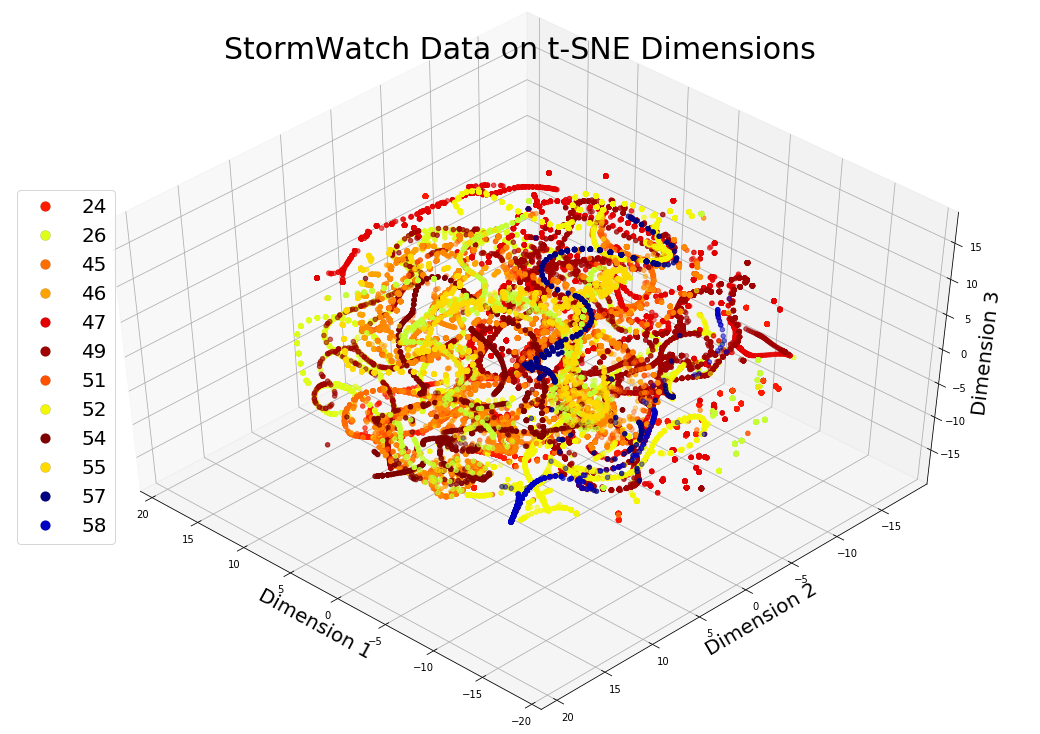

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# create tuple to match name in legend to profile id
labelTups = [('24', 24), ('26', 26), ('45', 45), ('46', 46), ('47', 47), ('49', 49), ('51', 51), ('52', 52), 
             ('54', 54), ('55', 55), ('57', 57), ('58', 58)]
# define the colormap
cmap = plt.cm.jet
# create list of colors from profile id
tag = list(df['id_profile'])
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# plot data on tsne components
sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=tag, cmap=cmap)
# assign colors to profile id
colors = [sc.cmap(sc.norm(i)) for i in [54, 45, 51, 49, 55, 57, 52, 46, 58, 47, 24, 26]]
# matplotlib does not support legends for 3D plots, so an empty 2D line plot is created for the legend
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
# plot legend
ax.legend(custom_lines, [lt[0] for lt in labelTups], loc='center left', prop={'size': 20})
# title plot and axes
ax.set_xlabel('Dimension 1', fontsize=20)
ax.set_ylabel('Dimension 2', fontsize=20)
ax.set_zlabel('Dimension 3', fontsize=20)
ax.set_title('StormWatch Data on t-SNE Dimensions', fontsize=30)
plt.show()

This diagram will require further analysis to fully understand, but each 'snake' correlates to one profile id as it moves through the data defined by the 3 t-SNE components. The movement of each 'snake' through the space correlates to the effect of each variable on the roofing profile, expressed through the t-SNE diagram. 

For example, the dark red snake in the middle-right of the plot represents profile 58. The table below shows a statistical summary of the proposed predictor variables for this profile id to help understand how each variable affect the profile id.    

In [7]:
# profile 58
df_58 = df[df['id_profile']==58].describe()
df_58[['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'absorb_pct', 
       'sat_pct']].describe()

,amc_pct,media_thickness_in,profile_thickness_in,slope_pct,rain_in,absorb_pct,sat_pct
count,8.000000,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000
mean,231.630439,2.320350e+02,2.349900e+02,231.383568,231.388228,-174.339782,232.095602
std,654.324124,6.541607e+02,6.529688e+02,654.423864,654.421982,1429.320876,654.136247
min,0.032694,3.786884e-14,1.243786e-13,0.000000,-0.003200,-3333.333300,0.091602
25%,0.291775,8.800000e-01,4.820000e+00,0.000000,0.000000,-0.558951,0.824775
50%,0.337757,8.800000e-01,4.820000e+00,0.009271,0.009210,0.018875,0.950407
75%,0.377400,8.800000e-01,4.820000e+00,0.025000,0.032552,27.186624,1.061775
max,1851.000000,1.851000e+03,1.851000e+03,1851.000000,1851.000000,1851.000000,1851.000000


## Means shift clustering to find patterns in the proposed prediction data

[Means shift clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift.predict) works to discover clusters in a dataset by comparing the density of points and their respective modes within clusters. Here, only the variables in the first group prposed in the introduction will be used, as well as sat_pct, to confirm that there are three clusters defined by sat_pct in this group.  

In [8]:
# create dataset for clustering
cluster = df[['slope_pct', 'rain_in', 'amc_pct', 'sat_pct', 'media_thickness_in', 'absorb_pct', 
              'profile_thickness_in', 'drain_type']]
# need to convert drain type to numerical value for clustering
# convert drain type to string so get_dummies works properly
cluster['drain_type'] = cluster['drain_type'].astype(str)
# get dummies for drain type 
dummies = pd.get_dummies(cluster['drain_type'])
# concat dummy columns back to cluster and drop original drain type column
cluster = pd.concat([cluster, dummies], 1).drop(['drain_type'], 1)
# import affinity propogation and run
from sklearn.cluster import MeanShift, estimate_bandwidth
band = estimate_bandwidth(cluster, quantile=0.3)
ms = MeanShift(bandwidth=band, bin_seeding=True)
ms.fit(cluster)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print('Means shift found {} clusters in the data'.format(len(labels_unique)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Means shift found 31 clusters in the data


[Means shift clustering](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/) works to discover clusters in a dataset by comparing the density of points and their respective modes within clusters. Here, only the variables in the first group prposed in the introduction will be used, as well as sat_pct, to confirm that there are three clusters defined by sat_pct in this group.

# Machine learning to predict absorption percentage

In [9]:
# import h2o
import h2o
h2o.init(max_mem_size=80)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 14 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_kyleknoebel_d7ibu9
H2O cluster total nodes:,1
H2O cluster free memory:,70.7 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


## Autoencoder on entire dataframe

An [autoencoder](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/) is an unsupervised neural network  model that uses hidden layers of neurons to reduce dimensionality in a dataframe. Like the t-SNE model, the autoencoder is a black box, and transforms the data so variable importance will cannot be shown from this model. The autoencoder will be used to find the loss function for further neural network models, and to search for anamolies in the data.  

In [10]:
# shuffle data before split
df = df.sample(frac=1)
# create dataframe for H2O
df_AE = h2o.H2OFrame(df)
# create training, test, validation frames
train,test,valid = df_AE.split_frame(ratios = [0.75, 0.15])
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'profile_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type']

y = 'absorb_pct'

AE = H2OAutoEncoderEstimator(activation="tanhwithdropout", hidden=[15], ignore_const_cols=False, epochs=1000,
                          l1=1.0E-5, l2=1.0E-5, loss='huber', input_dropout_ratio=0.2, rate=0.1, 
                          stopping_metric='auto', seed=1234, hidden_dropout_ratios=[0.1],  
                          distribution='huber', categorical_encoding='AUTO', elastic_averaging=True,
                          huber_alpha=0.01, max_w2=10.0)
AE.train(x=x, y=y, training_frame=train, validation_frame=valid)
# show error progression
AE._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse,validation_rmse,validation_mse
0,,2019-03-20 18:27:15,0.057 sec,0.00000 obs/sec,0.000000,0,0.0,0.382956,0.146655,0.382680,0.146444
1,,2019-03-20 18:27:21,5.372 sec,169853 obs/sec,31.281059,9,900394.0,0.073580,0.005414,0.073700,0.005432
2,,2019-03-20 18:27:26,10.911 sec,166470 obs/sec,62.565140,18,1800875.0,0.072853,0.005308,0.072888,0.005313
3,,2019-03-20 18:27:32,16.403 sec,165761 obs/sec,93.828134,27,2700749.0,0.071961,0.005178,0.072038,0.005189
4,,2019-03-20 18:27:37,21.876 sec,165535 obs/sec,125.089043,36,3600563.0,0.071368,0.005093,0.071524,0.005116
5,,2019-03-20 18:27:43,27.327 sec,165539 obs/sec,156.349430,45,4500362.0,0.073618,0.005420,0.073715,0.005434
6,,2019-03-20 18:27:48,32.846 sec,165205 obs/sec,187.617843,54,5400392.0,0.087710,0.007693,0.088130,0.007767
7,,2019-03-20 18:27:54,38.318 sec,165161 obs/sec,218.880420,63,6300254.0,0.070210,0.004930,0.070316,0.004944
8,,2019-03-20 18:27:59,43.778 sec,165182 obs/sec,250.149805,72,7200312.0,0.071853,0.005163,0.071780,0.005152
9,,2019-03-20 18:28:05,49.251 sec,165160 obs/sec,281.428710,81,8100644.0,0.071396,0.005097,0.071469,0.005108


### Anomaly exploration with Autoencoder

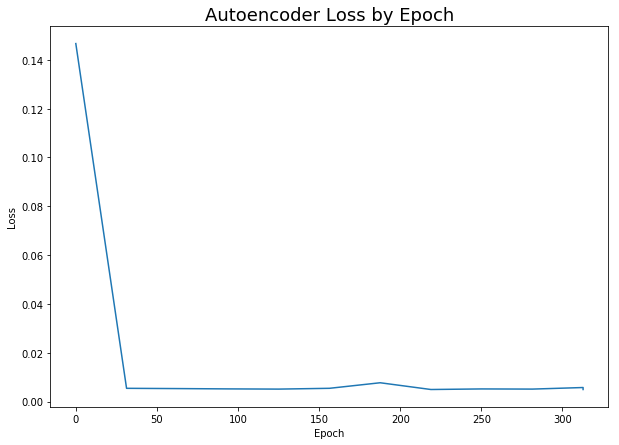

In [11]:
# plotting the loss
plt.figure(figsize=(10, 7))
scoring_history = AE.score_history()
plt.plot(scoring_history['epochs'], scoring_history['training_mse'])
plt.title('Autoencoder Loss by Epoch', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Plotting the loss function shows that the MSE levels out at about 25 epochs. This will be used in the neural network models below. 

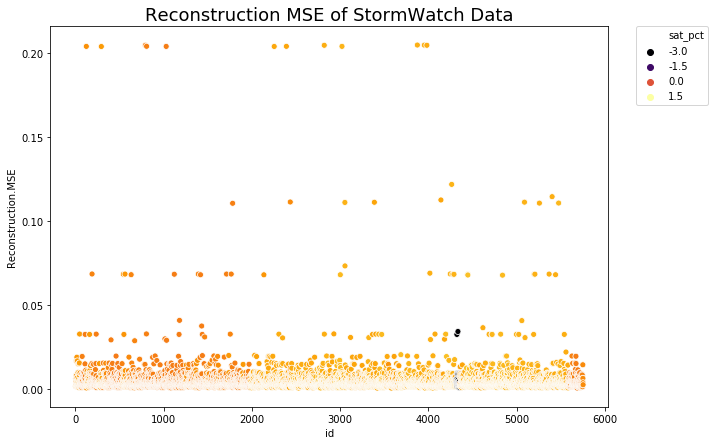

In [12]:
# plot data by MSE
plt.figure(figsize=(10, 7))
test_rec_error = AE.anomaly(test) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
sns.scatterplot(x='id', y='Reconstruction.MSE', data=test_rec_error_df, hue=df['sat_pct'], 
                palette='inferno')
plt.title('Reconstruction MSE of StormWatch Data', fontsize=18)
# place the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The dots above the large cluster are anamolies in the data. These anamolies may arise from collection errors, errors in data fetching from SQL, etc. Considering there are 38,297 observations in the data, these anamolies should not affect model accuracy. 

## Neural network to predict absorption percentage

How do the variables in the pred dataframe correlate to one another?  

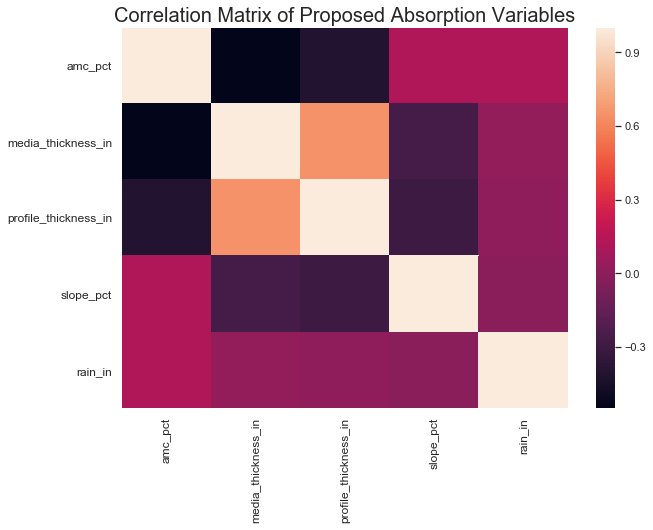

In [13]:
# create a correlation matrix of variables expected to effect absrob_pct
# drop sat_pct as it will not be modeled, only used to create tiers
corr=df[['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'drain_type', 'slope_pct', 'rain_in']].corr()
# plot as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr)
plt.title('Correlation Matrix of Proposed Absorption Variables', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

There is some collinerity between profile and media thickness, but it is not high enough to create imbalance issues in the model. 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


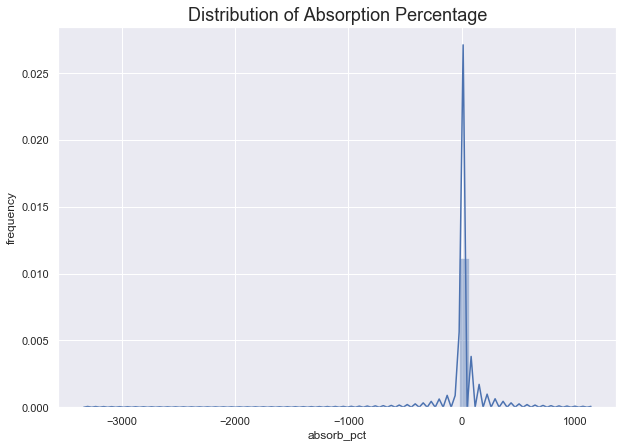

In [14]:
# plot the distribution of the response variable - absorption percentage
plt.figure(figsize=(10, 7))
sns.distplot(df['absorb_pct'])
plt.title('Distribution of Absorption Percentage', fontsize=18)
plt.ylabel('frequency')
plt.show()

H2O flow requires the distribution of the response variable as a parameter. Above a Huber distribution is shown for absorption percentage. 

### First Tier

In [15]:
print('There are {} rows in the first tier data'.format(len(first_tier)))
print('This is {}% of the total data'.format(((len(first_tier)/len(df))*100)))

There are 99 rows in the first tier data
This is 0.2585058881896754% of the total data


**Note:** there are only 99 rows in the first-tier data. The low amount of observations mean the model will likely not be able to predict absorption percentage accurately in this tier.

In [16]:
# shuffle data before split
first_tier = first_tier.sample(frac=1)
# create dataframe for H2O
first_tier_model = h2o.H2OFrame(first_tier)
# create training, test, validation frames
first_train,first_test,first_valid = first_tier_model.split_frame(ratios = [0.75, 0.15])
# import deep learning estimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'drain_type']

y = 'absorb_pct'

# deep learning parameters
first_model = H2ODeepLearningEstimator(activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='automatic', input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
first_model.train(x=x, y=y, training_frame=first_train, validation_frame=first_valid)
# show accuracy
first_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:28:13,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:28:13,0.015 sec,176000 obs/sec,2.444444,1,176.0,0.509086,0.09528,0.437313,0.172424,324.306090,25.404448,98.053148,-0.099670
2,,2019-03-20 18:28:13,0.028 sec,177909 obs/sec,27.180556,11,1957.0,0.428715,0.05370,0.320480,0.413100,324.395682,19.252630,98.001313,-0.100278


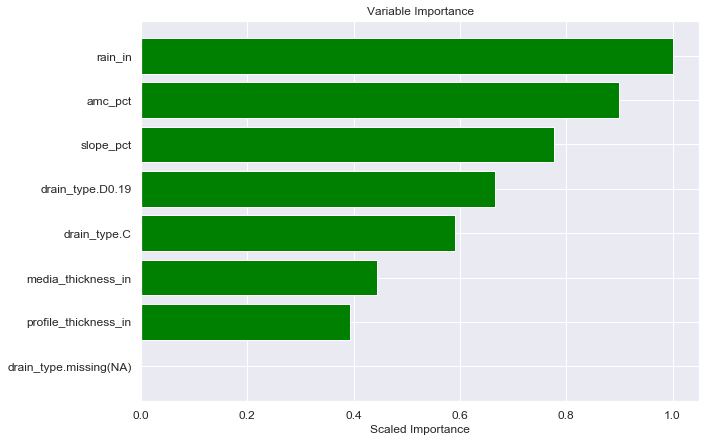

In [17]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = first_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = first_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The scoring history and variable importance for the first tier data are only shown to complete the report. These values should be disregarded as the accuracy for this tier is extremely low. The reason for this inaccuracy is the small amount of observations in the first tier. 

### Second Tier

In [18]:
print('There are {} rows in the second tier data'.format(len(second_tier)))
print('This is {}% of the total data'.format(int((len(second_tier)/len(df))*100)))

There are 6890 rows in the second tier data
This is 17% of the total data


In [19]:
# shuffle data before split
second_tier = second_tier.sample(frac=1)
# create dataframe for H2O
second_tier_model = h2o.H2OFrame(second_tier)
# create training, test, validation frames
second_train,second_test,second_valid = second_tier_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'drain_type']

y = 'absorb_pct'

# deep learning parameters
second_model = H2ODeepLearningEstimator(nfolds=3, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
second_model.train(x=x, y=y, training_frame=second_train, validation_frame=second_valid)
# show accuracy
second_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:28:14,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:28:14,0.444 sec,775529 obs/sec,2.558013,1,13184.0,9.278648,0.003489,0.247309,0.000575,43.199563,0.024416,1.719444,-0.001149
2,,2019-03-20 18:28:15,0.584 sec,908772 obs/sec,25.566938,10,131772.0,9.272853,0.007027,0.231907,0.001823,43.197432,0.053816,1.710672,-0.001051


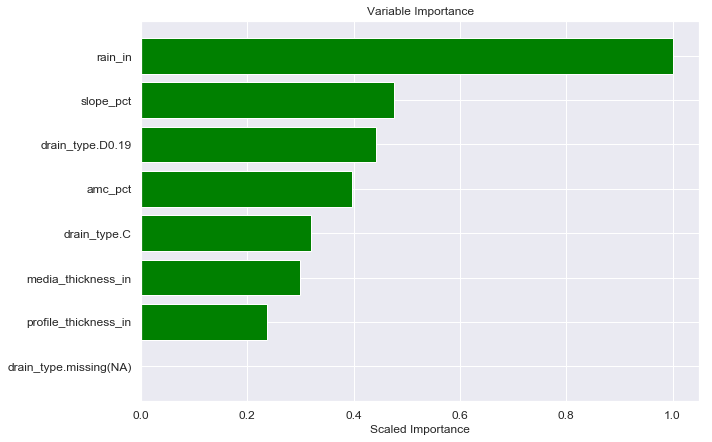

In [20]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = second_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = second_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The second tier shows a good accuracy score and balance. 

### Third Tier

In [21]:
print('There are {} rows in the third tier data'.format(len(third_tier)))
print('This is {}% of the total data'.format(int((len(third_tier)/len(df))*100)))

There are 31308 rows in the third tier data
This is 81% of the total data


In [22]:
# shuffle data before split
third_tier = third_tier.sample(frac=1)
# create dataframe for H2O
third_tier_model = h2o.H2OFrame(third_tier)
# create training, test, validation frames
third_train,third_test,third_valid = third_tier_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'drain_type']

y = 'absorb_pct'
# deep learning parameters
third_model = H2ODeepLearningEstimator(nfolds=5, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='huber',
                                        input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
third_model.train(x=x, y=y, training_frame=third_train, validation_frame=third_valid)
# show accuracy
third_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:28:19,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:28:19,2.546 sec,1037084 obs/sec,2.599652,1,61188.0,1.846160,0.004960,0.150351,-0.002526,16.645985,0.018860,0.522089,-0.000152
2,,2019-03-20 18:28:20,2.993 sec,1262334 obs/sec,26.011471,10,612232.0,1.847349,0.036192,0.263794,-0.003818,16.649793,0.156315,0.634251,-0.000610


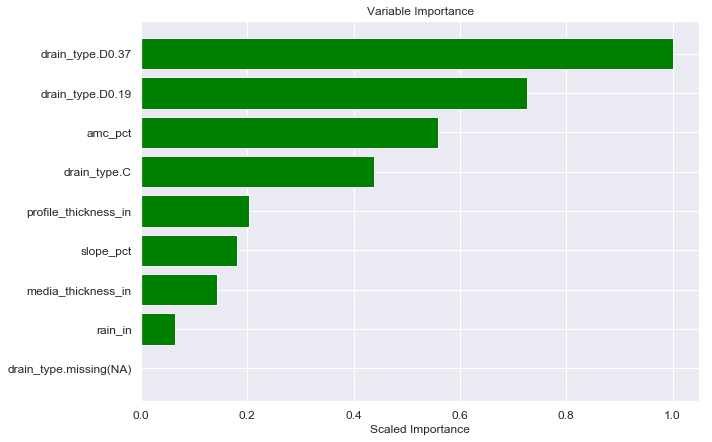

In [23]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = third_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = third_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The third tier model again shows low accuracy. This innacuracy is not due to a small amount of observations, but rather an error in the model/variable selection. It is possible, as well, that as saturation increases over 67% other factors not accounted for start affecting the absorption percentage. 

## Model on all three tiers

In [24]:
# shuffle data before split
all_data = df.sample(frac=1)
# create dataframe for H2O
all_data_model = h2o.H2OFrame(all_data)
# create training, test, validation frames
all_data_train,all_data_test,all_data_valid = all_data_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'profile_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type']

y = 'absorb_pct'
# deep learning parameters
all_data_model = H2ODeepLearningEstimator(nfolds=5, activation="rectifierwithdropout", hidden=[15, 7], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, ignore_const_cols=True,
                                        loss='huber', seed=1234, distribution='huber', 
                                        stopping_metric='rmse', hidden_dropout_ratios=[0.1, 0.1],
                                        elastic_averaging=True, categorical_encoding='AUTO')
all_data_model.train(x=x, y=y, training_frame=all_data_train, validation_frame=all_data_valid)
# show accuracy
all_data_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:28:31,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:28:31,8.855 sec,403250 obs/sec,2.589446,1,74198.0,13.246260,0.147902,0.367481,-0.000119,11.128847,0.142343,0.353419,0.000098
2,,2019-03-20 18:28:33,10.929 sec,366823 obs/sec,28.573672,11,818750.0,13.246059,0.102216,0.366661,-0.000089,11.129902,0.104895,0.352191,-0.000092


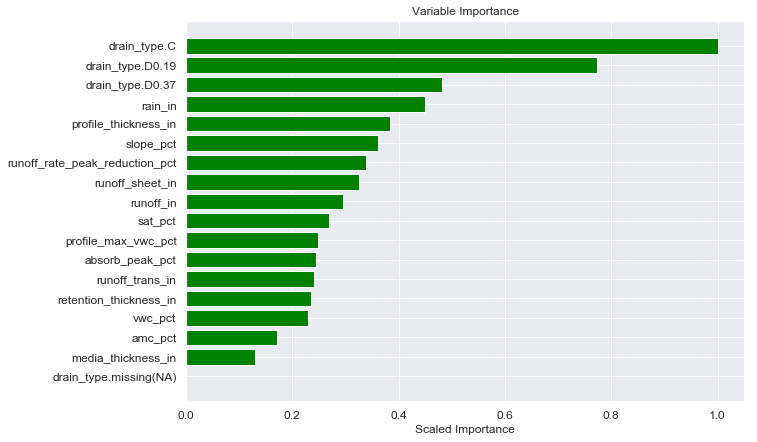

In [25]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = all_data_model._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = all_data_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The same issue arises when modeling the entire frame, as the majority of the data comes from the third tier. 

# Using absorb_delta_in as response variable

As only the seond tier model has a decent accuracy score, an absorb_delta_in variable will be created to measure the amount of water held in the profile at each increment. While this is not a measure of absoption precentage, it does provide some semblance to the original feature. In addition, this variable can be used to measure the absorption percentage (based on inches) for further testing.
To create this variable, the total runoff will be subtracted for the rainfall, both in inches, for each increment.

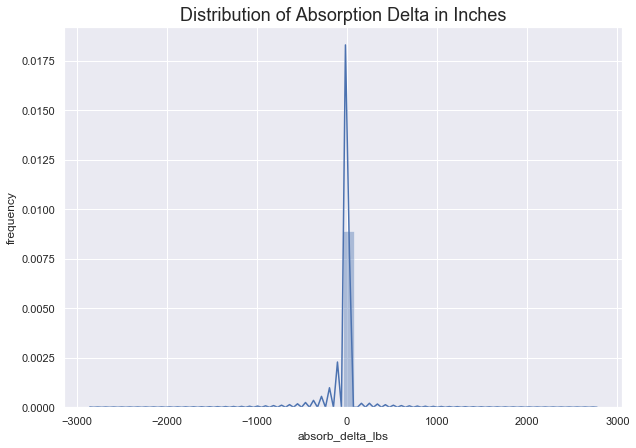

In [26]:
# create variable for difference in inches between rain and runoff
df['absorb_delta_in'] = df['rain_in']-df['runoff_in']
# plot the distribution of the response variable - absorption_delta_lbs_by_cassette
plt.figure(figsize=(10, 7))
sns.distplot(df['absorb_delta_lbs'])
plt.title('Distribution of Absorption Delta in Inches', fontsize=18)
plt.ylabel('frequency')
plt.show()

The new feature still shows a Huber distribution.

## Autoencoder to find epoch and anamoly detection

In [27]:
# shuffle data before split
test = df[['absorb_delta_in', 'runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 
           'amc_pct', 'vwc_pct', 'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 
           'media_thickness_in', 'profile_thickness_in', 'retention_thickness_in', 'profile_max_vwc_pct', 
           'drain_type']].sample(frac=1)
# create dataframe for H2O
df_new_variable = h2o.H2OFrame(test)
# create training, test, validation frames
train2,test2,valid2 = df_new_variable.split_frame(ratios = [0.75, 0.15])
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'profile_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type']

y = 'absorb_delta_lbs'

AE2 = H2OAutoEncoderEstimator(activation="tanhwithdropout", hidden=[15], ignore_const_cols=False, epochs=1000,
                          l1=1.0E-5, l2=1.0E-5, loss='huber', input_dropout_ratio=0.2, rate=0.1, 
                          stopping_metric='auto', seed=1234, hidden_dropout_ratios=[0.1], 
                          distribution='huber', categorical_encoding='AUTO', elastic_averaging=True,
                          huber_alpha=0.01, max_w2=10.0)
AE2.train(x=x, y=y, training_frame=train2, validation_frame=valid2)
# show error progression
AE2._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse,validation_rmse,validation_mse
0,,2019-03-20 18:28:34,0.046 sec,0.00000 obs/sec,0.000000,0,0.0,0.383744,0.147259,0.383815,0.147314
1,,2019-03-20 18:28:40,5.370 sec,169730 obs/sec,31.419660,9,900079.0,0.075279,0.005667,0.076386,0.005835
2,,2019-03-20 18:28:45,10.773 sec,168489 obs/sec,62.838831,18,1800144.0,0.076015,0.005778,0.077076,0.005941
3,,2019-03-20 18:28:51,16.343 sec,166351 obs/sec,94.252452,27,2700050.0,0.081314,0.006612,0.082293,0.006772
4,,2019-03-20 18:28:56,21.729 sec,166734 obs/sec,125.690020,36,3600642.0,0.081634,0.006664,0.082539,0.006813
5,,2019-03-20 18:29:01,27.107 sec,167016 obs/sec,157.122351,45,4501084.0,0.082749,0.006847,0.083639,0.006996
6,,2019-03-20 18:29:07,32.464 sec,167306 obs/sec,188.553077,54,5401480.0,0.078969,0.006236,0.079965,0.006394
7,,2019-03-20 18:29:12,37.942 sec,166973 obs/sec,219.979125,63,6301742.0,0.071751,0.005148,0.072787,0.005298
8,,2019-03-20 18:29:18,43.503 sec,166414 obs/sec,251.407722,72,7202077.0,0.072178,0.005210,0.073384,0.005385
9,,2019-03-20 18:29:23,48.905 sec,166510 obs/sec,282.830628,81,8102249.0,0.078972,0.006237,0.079717,0.006355


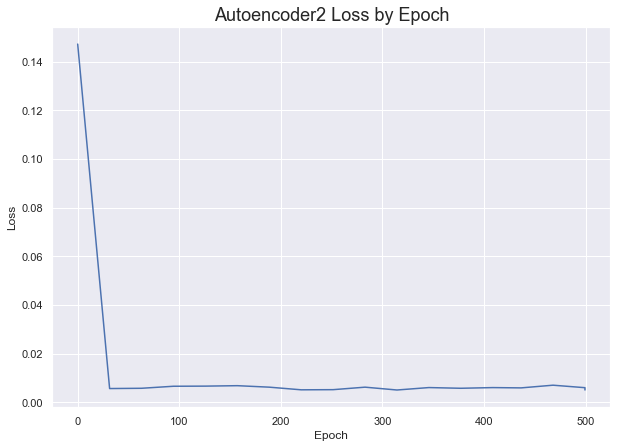

In [28]:
# plotting the loss
plt.figure(figsize=(10, 7))
scoring_history = AE2.score_history()
plt.plot(scoring_history['epochs'], scoring_history['training_mse'])
plt.title('Autoencoder2 Loss by Epoch', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

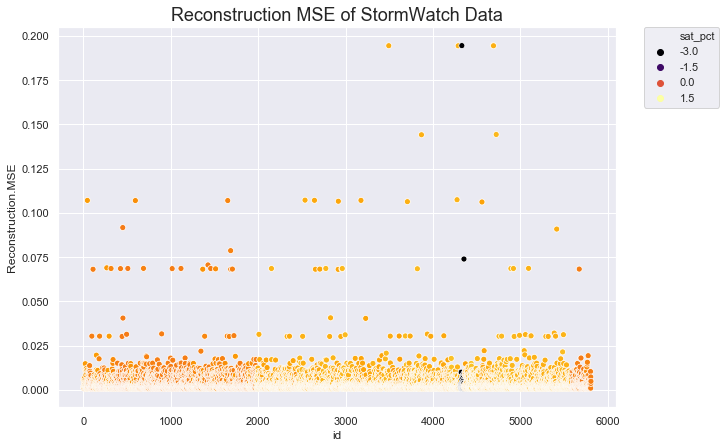

In [29]:
# plot data by MSE
%matplotlib inline
plt.figure(figsize=(10, 7))
test_rec_error = AE2.anomaly(test2) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
sns.scatterplot(x='id', y='Reconstruction.MSE', data=test_rec_error_df, hue=df['sat_pct'], 
                palette='inferno')
plt.title('Reconstruction MSE of StormWatch Data', fontsize=18)
# place the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The data with the new feature shows the same loss function, and similar anamoly distribution.  

## Compare to second tier testing for absorption percentage

In [30]:
# get second tier data with absorb_delta_in 
second_tier2 = df[(df['sat_pct']>0.3333) & (df['sat_pct']<=0.6666)]
# create dataframe for H2O
df_new_variable_tier2 = h2o.H2OFrame(second_tier2)
# create training, test, validation frames
second_train2,second_test2,second_valid2 = df_new_variable_tier2.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'drain_type']

y = 'absorb_delta_in'

# deep learning parameters
second_model2 = H2ODeepLearningEstimator(nfolds=3, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                         seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
second_model2.train(x=x, y=y, training_frame=second_train2, validation_frame=second_valid2)
# show accuracy
second_model2._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:30:04,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:30:04,0.441 sec,883466 obs/sec,2.573204,1,13252.0,0.008321,4.145569e-07,0.002990,0.251659,0.006832,3.687500e-07,0.002692,0.264265
2,,2019-03-20 18:30:04,0.594 sec,952756 obs/sec,28.120194,11,144819.0,0.007499,5.830465e-07,0.002396,0.392176,0.005760,5.010624e-07,0.002066,0.476964


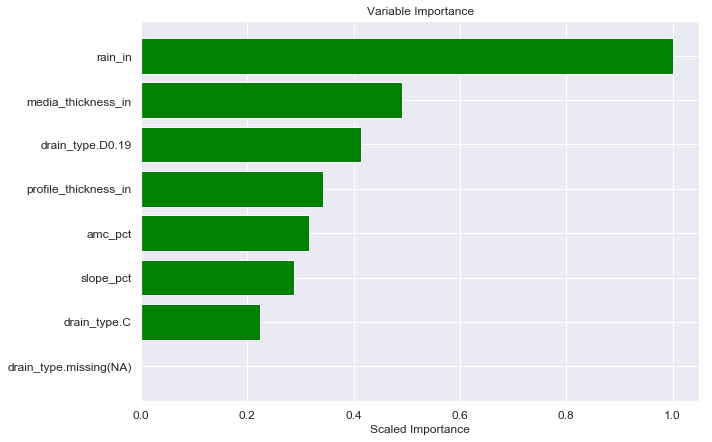

In [31]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = second_model2._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = second_model2._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Get proper variable importance for the third tier

In [32]:
# get second tier data with absorb_delta_in 
third_tier2 = df[df['sat_pct']>0.6666]
# create dataframe for H2O
df_new_variable_tier3 = h2o.H2OFrame(third_tier2)
# create training, test, validation frames
third_train2,third_test2,third_valid2 = df_new_variable_tier3.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'profile_thickness_in', 'slope_pct', 'rain_in', 'drain_type']

y = 'absorb_delta_in'

# deep learning parameters
third_model2 = H2ODeepLearningEstimator(nfolds=3, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
third_model2.train(x=x, y=y, training_frame=third_train2, validation_frame=third_valid2)
# show accuracy
third_model2._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:30:08,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:30:08,1.376 sec,962822 obs/sec,2.551832,1,59695.0,0.009234,0.000003,0.004123,0.330998,0.011060,0.000003,0.004007,0.235616
2,,2019-03-20 18:30:09,1.962 sec,1063577 obs/sec,28.097764,11,657291.0,0.008417,0.000003,0.003572,0.444098,0.010544,0.000003,0.003496,0.305200


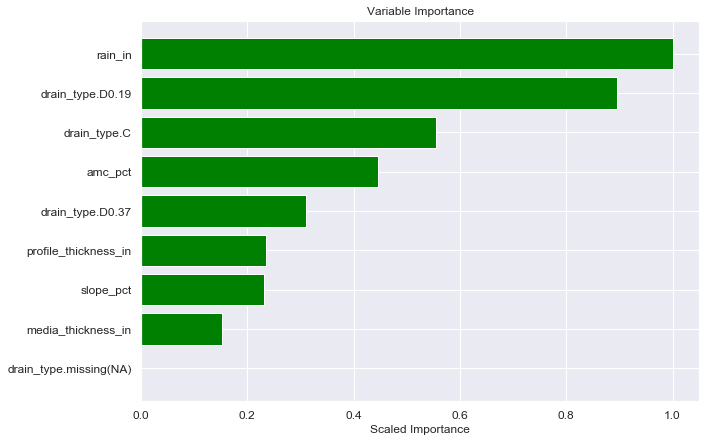

In [33]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = third_model2._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = third_model2._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Test new variable on entire frame

In [34]:
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct',  'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'profile_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type']

y = 'absorb_delta_in'

# deep learning parameters
test_model = H2ODeepLearningEstimator(nfolds=5, activation="tanhwithdropout", hidden=[15, 7], 
                                        epochs=25, l1=1.0E-5, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.2, rate=0.2, 
                                        stopping_metric='rmse', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.1,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True, categorical_encoding='AUTO')
test_model.train(x=x, y=y, training_frame=train2, validation_frame=valid2)
# show accuracy
test_model._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-20 18:30:20,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-20 18:30:21,11.812 sec,249838 obs/sec,2.590219,1,74202.0,0.006881,5.190442e-07,0.002816,0.552767,0.010702,5.773454e-07,0.003116,0.334506
2,,2019-03-20 18:30:23,14.431 sec,285462 obs/sec,28.579153,11,818707.0,0.008508,1.137354e-06,0.003615,0.316266,0.011915,1.244392e-06,0.003941,0.174982


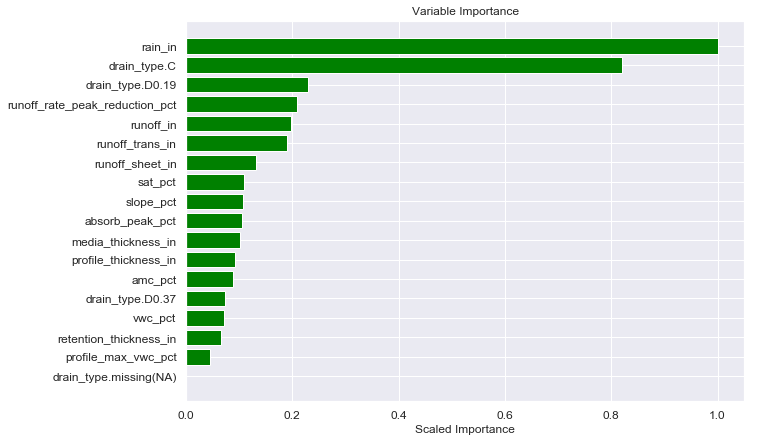

In [35]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = test_model._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = test_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Summary

Since the models that use the engineered absorb_delta_in variable have higher accuracy, the variable importance plots calculated from these models should be employed. As there is not enough data in the first tier, the models run on this tier should be discarded. Furthermore, the models run on the entire dataframe, as well as their variable importance, may change as more first-tier data is collected.  

The StormWatch variable sheet shows that the absorption percentage is calculated from the change in the weight of the cassette during each increment. Since this report uses variables with the inch metric, it is possible that the absorption percentage is not a good response variable when using inches, as it is calculated from pounds.

The fact that no patterns can be found in the entire dataframe suggests that some variables necessary to linking the data is missing. As more temperature and plant health data are collected, these variables should be modeled to ascertain if they have any effect on absoroption percentage, as well as any other variable expected to affect absorption percentage.

In addition, the three tiers based on saturation percentage may not have an affect on absorption percentage. While the autoencoder MSE plots show three clusters of saturation percentage, one has very few observations. The agglomerative clustering method also did not find clusters based on saturation percentage. More testing will be needed to test this hypothesis.  